In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys

import os
import datetime
import glob
import h5py

sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
import scipy.constants as c

import astropy.units as u
import astropy.time as at
import astropy.coordinates as acoord

sys.path.append('..')

import jabble.dataset
import jabble.quickplay
import jabble.loss
import jabble.dataset
import jabble.model
import jabble.physics

jax.config.update("jax_enable_x64", True)

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
hf = h5py.File('/scratch/mdd423/simulacra/out/data_e60_p7.0_a100.0_l380.0-690.0_salp0.4_z-1.0_T4800_g1.0_ra183.33716301338228 deg_dec49.411485886697704 deg_loc-73.91145844610405-40.69140120265266.h5','r')

In [4]:
location = acoord.EarthLocation.from_geocentric(hf['parameters']['detector']['loc']['value'][()][0] * u.Unit(hf['parameters']['detector']['loc']['unit'][()][0]) \
                            ,hf['parameters']['detector']['loc']['value'][()][1] * u.Unit(hf['parameters']['detector']['loc']['unit'][()][0]) \
                            ,hf['parameters']['detector']['loc']['value'][()][2] * u.Unit(hf['parameters']['detector']['loc']['unit'][()][0]))

# h5['parameters']['detector']['loc']['unit'],h5['parameters']['detector']['loc']['value']

In [5]:
target = acoord.SkyCoord(ra=hf['parameters']['star']['target']['ra'][0]*u.degree, dec=hf['parameters']['star']['target']['dec'][0]*u.degree, frame='icrs')

In [6]:
import astropy.time as atime

obs_times = at.Time(np.array(hf['data']['obs_times']).tolist(),format='isot')

In [7]:
hf['parameters']['tellurics'].keys()

<KeysViewHDF5 ['_epoches', '_humidity', '_lambmax', '_lambmin', '_name', '_pressure', '_temperature', 'airmass', 'check_property', 'check_shape_type', 'epoches', 'generate_transmission', 'get_airmass', 'humidity', 'lambmax', 'lambmin', 'loc', 'over_resolution', 'plot', 'plot_interpolated', 'pressure', 'temperature', 'wave_padding']>

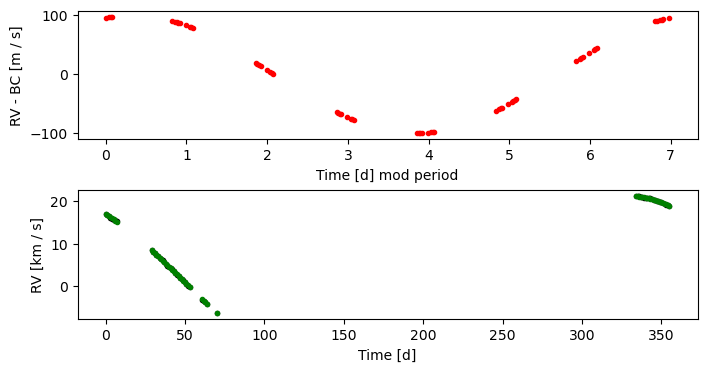

In [8]:
times = obs_times
rv = np.array(hf['data']['rvs']['value'][:]) * u.m/u.s
bc  = [target.radial_velocity_correction(obstime=time,location=location).to(u.km/u.s).value for time in times] * u.km/u.s
# print(rv,bc)
eprv = rv - bc

period = hf['parameters']['star']['period']['value'][()] * u.day
fig, axes = plt.subplots(2,figsize=(8,4))
# plt.title('EPRV')
v_unit = u.m/u.s
axes[0].plot(([(time - min(times)).to(u.day).value % period.to(u.day).value for time in times]),eprv.to(v_unit).value,'.r')
axes[0].set_ylabel('RV - BC [{}]'.format(v_unit))
axes[0].set_xlabel('Time [d] mod period')

# plt.title('RV')
v_unit = u.km/u.s
axes[1].plot(([(time - min(times)).to(u.day).value for time in times]),rv.to(v_unit).value,'.k')
axes[1].plot(([(time - min(times)).to(u.day).value for time in times]),bc.to(v_unit).value,'.g')

axes[1].set_ylabel('RV [{}]'.format(v_unit))
axes[1].set_xlabel('Time [d]')
plt.subplots_adjust(hspace=0.4)
plt.show()

Holy shit it works yes yesy yes yes

In [9]:
hf['parameters']['detector']['resolution'][:]
# hf['parameters']['star']['target']['dec'][0],hf['parameters']['star']['target']['ra'][0]
# for key in hf['parameters']['star'].keys():
#     if not isinstance(hf['parameters']['star'][key],type(hf['parameters']['star'])):
#         print(key, hf['parameters']['star'][key][:])

array([b'115000.0'], dtype=object)

In [10]:
def get_dataset(hf,device,l_index,h_index,epsilon=np.exp(-11),contin_norm=False):
    ys = []
    xs = []
    yivar = []
    mask = []

    bcs = []
    airmass = []
    times = []
    star_ids = []
    
    flux = np.array(hf['data']['flux'][:,l_index:h_index])
    err = np.array(hf['data']['ferr'][:,l_index:h_index])/flux
    ma = np.array(hf['data']['mask'][:,l_index:h_index])
    wave = np.array(np.log(hf['data']['wave']['value'][l_index:h_index]))
    wave = wave[None,:] * np.ones((flux.shape[0]))[:,None]
    ma = ma | np.isnan(err) | np.isinf(err) | np.isinf(flux) | (flux <= epsilon) | np.isnan(flux)
    # clean this shit
    flux[ma] = 1.0
    info     = 1/err**2
    info[ma] = 0.0
    wave[ma] = np.min(wave)

    temp = np.zeros(flux.shape)
    for iii in range(flux.shape[0]):
        if contin_norm:
            contin = fit_continuum(wave[iii,:], np.log(flux[iii,:]), info[iii,:], order=6, nsigma=[0.3,3.0], maxniter=50)
            temp[iii,:] = (np.log(flux[iii,:]) - contin)
        else:
            temp[iii,:] = np.log(flux[iii,:])
    ys = [temp[iii,:] for iii in range(temp.shape[0])]
    xs = [wave[iii,:] for iii in range(temp.shape[0])]
    yivar = [info[iii,:] for iii in range(temp.shape[0])]
    mask = [ma[iii,:].astype(bool) for iii in range(temp.shape[0])]
    
    altz = target.transform_to(acoord.AltAz(obstime=obs_times,location=location))

    airmass = [target.transform_to(acoord.AltAz(obstime=time,location=location)).secz for time in obs_times]
    
    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)
    
    dataset.metadata['times']    = jnp.array([time.mjd for time in obs_times])
    dataset.metadata['airmass']  = jnp.array(airmass)
    dataset.to_device(device)
    
    return dataset

In [13]:
cpus = jax.devices("cpu")
print(location.lat,location.lon)
# gpus = jax.devices("gpu")

40d41m29.04432955s -73d54m41.25040597s


In [14]:
obs_times.jd2#).shape

array([-0.04164578, -0.02779841, -0.04395269, -0.01446558, -0.01656907,
        0.00482201, -0.00569545, -0.02560853, -0.03935869, -0.03000918,
       -0.00368076, -0.04627907,  0.00286543, -0.01238367, -0.0186941 ,
        0.00675699, -0.04862455, -0.03709174, -0.03224062, -0.0234397 ,
       -0.00773199, -0.08580046, -0.08324692, -0.08836657, -0.08070648,
       -0.20606325, -0.20340987, -0.20871005, -0.2007502 , -0.09094522,
       -0.21134887, -0.1980866 , -0.21397759, -0.19541752, -0.00168791,
       -0.19274321, -0.19005981, -0.0935369 , -0.21659894, -0.07817968,
       -0.18737098, -0.24703493, -0.18467786, -0.18198083, -0.24953297,
       -0.17928032, -0.21921256, -0.24452579, -0.17657924, -0.09613964,
       -0.1738755 , -0.26879858, -0.17116845, -0.16845514, -0.16574046,
       -0.2520195 , -0.16302486, -0.22181816, -0.16030881, -0.15759333])

In [15]:
resolution = 115_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb_s = 1e-6
lmb_t = 1e-6

norm_p_val = 2
norm_pts   = 2

total_pixels = 4096

star_name = 'simulated_data'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)

<h2>Work Horse</h2>
First we have to cut some of the data that is not the correct object. Then loop through loading the datasets, fitting models, and saving each bit.

In [16]:
print(hf['data']['flux'].shape[1]/4096)
order_indices = np.arange(0,hf['data']['flux'].shape[1]//total_pixels + 1,1)
print(hf['data']['wave']['value'].shape,hf['data']['flux'].shape)
print(out_dir)

33.935546875
(139000,) (60, 139000)
/scratch/mdd423/wobble_jax/out/26-01-20


In [17]:
# dataset = jabble.model.load('../out/25-06-23/HD4307/HD4307_data_o67-67_norm.pkl')
# model = jabble.model.load('../out/25-06-23/HD4307/HD4307_model_o67-67_norm.pkl')

def this_fucking_plot(dataset,model):
    rv_inds = [0,1,2,3]
    
    plt_epoches = [0,1,2]
    plt_width = np.arange(-10,10,4)
    lrange = np.array([np.mean(np.exp(dataset[plt_epoch].xs)) for plt_epoch in plt_epoches]).astype(int)[None,:] + plt_width[:,None]
    fig, axes = plt.subplots(3,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex='col',sharey='row',\
                                 facecolor=(1, 1, 1),height_ratios=[4,4,1],dpi=200)
    
    # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
    model.fit()
    model.display()
    
    plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
    print(axes.shape)
    for ii in range(axes.shape[1]):
        axes[0,ii] = make_subplot_norm(axes[0,ii],model,dataset,None,plt_epoches[0],cpus[0],lrange[:,ii])
    # plt.show()
    
    # fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),4),sharex='col',sharey='row',\
    #                              facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)
    
    # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
    model.fit()
    model.display()
    
    plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
    print(axes.shape)
    for ii in range(axes.shape[1]):
        axes[1:,ii] = make_subplot(axes[1:,ii],model,dataset,plt_epoches[0],cpus[0],lrange[:,ii])
    plt.show()

def make_subplot_norm(axes,model,dataset,norm_dataset,plt_epoch,device,lrange):

    model.fix()
    datablock = dataset.blockify(device,return_keys=True)
    
    datarow = datablock.ele(plt_epoch,device)
    # metarow = jabble.loss.dict_ele(meta,plt_epoch,device)

    # ndata,nmeta = norm_dataset.blockify(device)
    # ndatarow = jabble.loss.dict_ele(ndata,plt_epoch,device)
    # nmetarow = jabble.loss.dict_ele(nmeta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,datarow['meta'])
    yplot_norm_stel = model[0]([],xplot,datarow['meta'])
    yplot_norm_tell = model[1]([],xplot,datarow['meta'])
    yplot_norm      = model[2]([],xplot,datarow['meta'])
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    axes.set_xlim(xplot.min(),xplot.max())
    
    # Data
    # print(datarow)
    axes.errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)

    # axes.errorbar(ndatarow["xs"][~ndatarow["mask"]],ndatarow["ys"][~ndatarow["mask"]],\
    #                  yerr=1/np.sqrt(ndatarow["yivar"][~ndatarow["mask"]]),fmt='.k',zorder=2,alpha=0.3,ms=5)

    # Stellar Model        
    axes.plot(xplot,yplot_norm_stel + yplot_norm,'-r',linewidth=1.2,zorder=10,alpha=0.1,ms=6)
    # Telluric M
    axes.plot(xplot,yplot_norm_tell + yplot_norm,'-b',linewidth=1.2,zorder=10,alpha=0.1,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    axes.plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    # axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
    #                          'k',where='mid',zorder=1,alpha=0.3,ms=3)

    # if "orders" in model.metadata:
        
    #     axes[0].text(np.log(lrange.min()+0.1),0.3,"Order: ${}$".format(model.metadata["orders"][plt_epoch]))
    # axes[0].text(np.log(lrange.max()-0.1),0.3,"MJD: ${}$".format(model.metadata["times"][plt_epoch]))

    # axes[0].set_ylim(-2.5,0.5)
    # axes.set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes.set_xticks(np.log(lrange))
    # axes[1].set_xticks(np.log(lrange))

    axes.set_xticklabels(['' for x in lrange])
    # axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    # axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

import jabble.plotting
#     plt.show()

In [18]:
# dataset.metadata

In [19]:
# def clip_ends(norm_dataset,dataset):
#     for dataframe,norm_dataframe in zip(dataset,norm_dataset):
#         new_mask  = np.zeros(norm_dataframe.mask.shape,dtype=bool)
#         indices, = np.where(norm_dataframe.mask == 0)
#         i = np.min(indices)
#         j = np.max(indices)
        
#         new_mask[:(i+1)] = True
#         new_mask[j:] = True
    
#         dataframe.mask = (dataframe.mask + new_mask).astype(bool)
#     return dataset 

# device_store = cpus[0]
# device_op = gpus[0]
batch_size = 5000

clip_pixels = 500

order_indices = np.arange(0,hf['data']['flux'].shape[1]//total_pixels + 1,1)
print(order_indices)

# orders_s = [[67]]
# out_dir = '/scratch/mdd423/wobble_jax/out/25-07-17/'
# import copy
for order_index in [22]:
    l_index = total_pixels * order_index
    h_index = min(total_pixels * (order_index + 1),hf['data']['flux'].shape[1] - 1)
#     print(l_index,h_index)
#     norm_data_name = os.path.join(out_dir,star_name,'sim_ndata_p{}-{}.pkl'.format(l_index,h_index))
#     data_name = os.path.join(out_dir,star_name,'sim_data_p{}-{}.pkl'.format(l_index,h_index))
#     model_name = os.path.join(out_dir,star_name,'sim_model_p{}-{}.pkl'.format(l_index,h_index))
#     if not os.path.isfile(model_name) or True:
#         dataset = get_dataset(hf,device_op,l_index + clip_pixels,h_index - clip_pixels,contin_norm=False)

#         init_rvs = -np.array(bc.to(u.m/u.s).value)
#         rest_rvs = np.zeros(init_rvs.shape)#ccf_arr_obj['ccf_rvc'] - ccf_arr_obj['ccf_rvs']

#         model_grid = jabble.model.create_x_grid(
#             np.concatenate(dataset.xs), vel_padding.to(u.m/u.s).value, 2 * resolution
#         )
        
#         model =  jabble.quickplay.get_wobble_model(-init_rvs, dataset.metadata['airmass'], model_grid, p_val,rest_vels=rest_rvs, which_key='times')
#             # dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,dataset.metadata['airmass'])
#         reg_s = lmb_s*jabble.loss.L1Reg([0,1]) * np.nansum(dataset.yivar)
#         reg_t = lmb_t*jabble.loss.L1Reg([1,1]) * np.nansum(dataset.yivar)
#         print(np.nansum(dataset.yivar) * lmb_s)

#         loss = jabble.loss.ChiSquare()

#         model.display()
#         norm_dataset = get_dataset(hf,device_op,l_index,h_index,contin_norm=False)
#         norm_model   = jabble.quickplay.get_normalization_model(dataset,norm_p_val,norm_pts)
#         model += norm_model
#         model.metadata = dataset.metadata

#         model = jabble.quickplay.train_norm(model, norm_dataset, loss, device_store, device_op, batch_size,maxiter=2,nsigma=[1,3])
#         # dataset = clip_ends(norm_dataset,dataset)
#         model = jabble.quickplay.train_cycle(model, dataset, loss + reg_s + reg_t, \
#                                              device_store, device_op, batch_size,options={'maxiter':1_000_000,'factr':1,'maxfun':1_000_000})
#         model.fix()
#         model.to_device(device_store)
#         dataset.to_device(device_store)
#         this_fucking_plot(dataset,model)
        
#         model.to_device(device_op)
#         dataset.to_device(device_op)
#         jabble.model.save(norm_data_name,norm_dataset)
#         jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss,rv_ind=[0,0])
#     else:
#         print('skipping {}'.format(model_name))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [20]:
norm_dataset = jabble.model.load(os.path.join('/scratch/mdd423/wobble_jax/out/25-12-18/',star_name,'sim_ndata_p{}-{}.pkl'.format(l_index,h_index)))
dataset = jabble.model.load(os.path.join('/scratch/mdd423/wobble_jax/out/25-12-18/',star_name,'sim_data_p{}-{}.pkl'.format(l_index,h_index)))
model = jabble.model.load(os.path.join('/scratch/mdd423/wobble_jax/out/25-12-18/',star_name,'sim_model_p{}-{}.pkl'.format(l_index,h_index)))

In [44]:
hf['theory']['total']['wave']['value'].keys()#,hf['theory']['star']['flux']

<KeysViewHDF5 ['unit', 'value']>

{CpuDevice(id=0)}


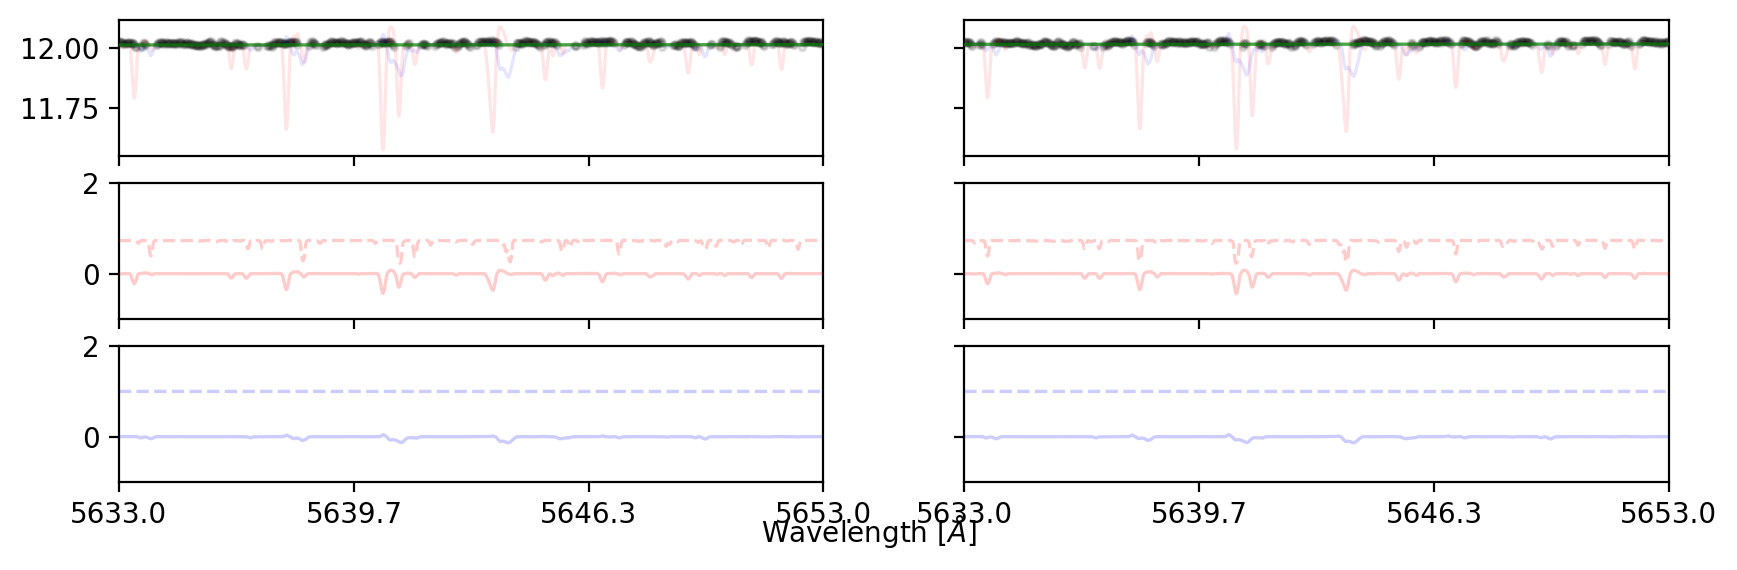

In [48]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange,the_flux=None,the_wave=None):

    model.fix()
    datablock = dataset.blockify(device,return_keys=True)
    
    datarow = datablock.ele(plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,datarow['meta'])
    yplot_norm_stel = model[0]([],xplot,datarow['meta'])
    yplot_norm_tell = model[1]([],xplot,datarow['meta'])
    yplot_norm      = model[2]([],xplot,datarow['meta'])
    # for epoch in np.where(indices):
    yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])

    axes[0].set_xlim(xplot.min(),xplot.max())

    # velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]] - yhat_norm,\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=3)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.2,ms=3)
    # Telluric M
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.2,ms=3)

    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    # axes[0].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    axes[0].set_ylim(-1,2)
    axes[1].set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

def compare_theory_model(axes,model,dataset,hf,plt_epoch,device,lrange):
    
    model.fix()
    datablock = dataset.blockify(device,return_keys=True)
    datarow = datablock.ele(plt_epoch,device)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,datarow['meta'])
    yplot_norm_stel = model[0]([],xplot,datarow['meta'])
    yplot_norm_tell = model[1]([],xplot,datarow['meta'])
    yplot_norm      = model[2]([],xplot,datarow['meta'])
    # for epoch in np.where(indices):
    yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],datarow['meta'])
    
    # Data
    # for ii in range(len(axes)):
    #     axes[ii].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]] - yhat_norm,\
    #                      yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=3)

    # Stellar Comparison        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.2,ms=3)
    stell_flux = hf['theory']['star']['flux'][plt_epoch,:]
    stell_flux -= stell_flux.min()
    stell_flux /= stell_flux.max()
    axes[0].plot(np.log(hf['theory']['total']['wave']['value'][:]),stell_flux,\
                 '--r',linewidth=1.2,zorder=10,alpha=0.2,ms=3)
    
    # Telluric Comparison
    axes[1].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.2,ms=3)
    axes[1].plot(np.log(hf['theory']['total']['wave']['value'][:]),hf['theory']['tellurics']['flux'][plt_epoch,:],\
                 '--b',linewidth=1.2,zorder=10,alpha=0.2,ms=3)

    axes[0].set_ylim(-1,2)
    axes[1].set_ylim(-1,2)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

norm_dataset.to_device(cpus[0])

dataset.to_device(cpus[0])
model.to_device(cpus[0])
print(model[0][0].p.devices())
sorted_rvs = np.argsort(model[0][0].p)
plt_epoches = [sorted_rvs[0],sorted_rvs[-1]]

fig, axes = plt.subplots(3,len(plt_epoches),figsize=(10,3),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[3,3,3],dpi=200)


plt_width = np.linspace(-10,10,4)
# lrange = np.linspace(int(np.min()),\
#                      int(np.max(np.exp(dataset[plt_epoch].xs))),4)[:,None]
# lrange = int(np.mean(lrange)) + plt_width[:,None]
# lrange = np.array([np.mean(np.exp(dataset[plt_epoch].xs)) for plt_epoch in plt_epoches]).astype(int)[None,:] + plt_width[:,None]

# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 

# plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
# axes[0] = make_subplot_norm(axes[0],model,dataset,norm_dataset,plt_epoches[0],cpus[0],lrange[:,0])

# plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
# axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
for ii,plt_epoch in enumerate(plt_epoches):
    lrange = int(np.mean(np.exp(dataset[plt_epoch].xs))) + plt_width
    axes[0,ii] = make_subplot_norm(axes[0,ii],model,norm_dataset,dataset,plt_epoch,cpus[0],\
                                   lrange)
    axes[1:,ii] = compare_theory_model(axes[1:,ii],model,dataset,hf,plt_epoch,cpus[0],lrange)
    # the_flux = np.array(hf['theory']['star']['flux'][plt_epoch,:])
    # the_flux -= the_flux.min()
    # the_flux /= the_flux.max()
    # the_flux = np.log(the_flux)
    # axes[1:,ii] = make_subplot(axes[1:,ii],model,dataset,plt_epoch,cpus[0],lrange)
fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
plt.show()

In [22]:
hf['theory']['star']['flux'],hf['theory']['total']['wave']['value']

(<HDF5 dataset "flux": shape (60, 3620062), type "<f8">,
 <HDF5 dataset "value": shape (3620062,), type "<f8">)

-760.0667520489197 m / s
-2.2737367544323206e-13 m / s
-AdditiveModel----------------------------------------------------60
  0-CompositeModel------------------------------------------------60
  0  0-ShiftingModel----------------------------------------------60
  0  1-CardinalSplineMixture---------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture---------------------------------------0
  1  2-StretchingModel---------------------------------------------0
  2-CompositeModel-------------------------------------------------0
  2  0-ShiftingModel-----------------------------------------------0
  2  1-NormalizationModel------------------------------------------0


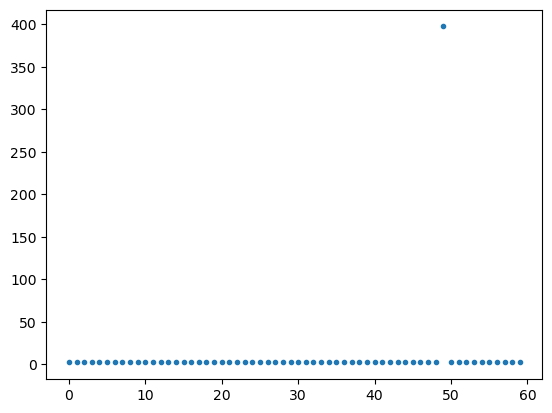

9.193889599544699 m / s 397.5373646170291 m / s


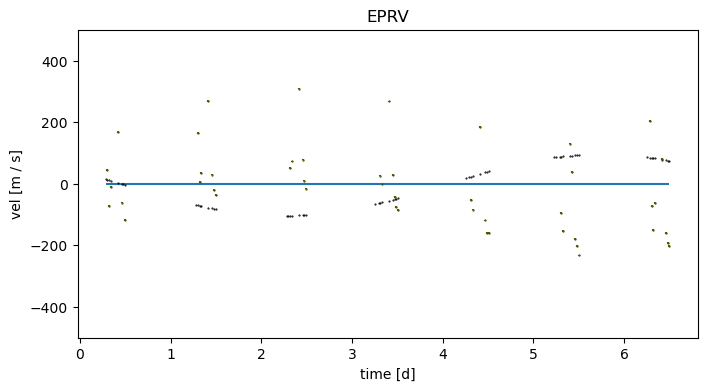

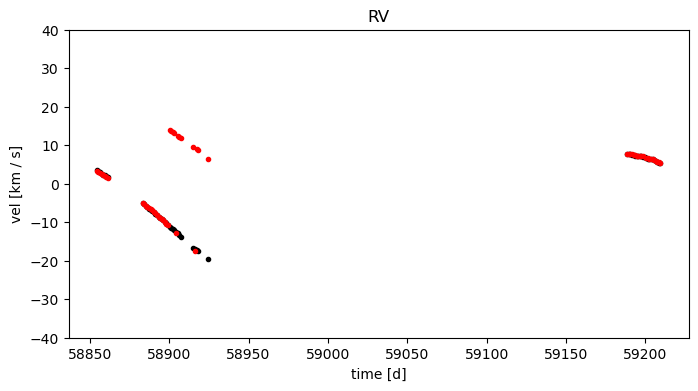

In [27]:
times = obs_times
model.to_device(cpus[0])

datablock = dataset.blockify(cpus[0],return_keys=True)
jab_sort= np.argsort(datablock.meta_keys['times'])
sim_sort = np.argsort(obs_times.mjd)

rv_est = jabble.physics.velocities(model[0][0].p) * u.m/u.s

bc  = [target.radial_velocity_correction(obstime=time,location=location).to(u.km/u.s).value \
       for time in times] * u.km/u.s
bc -= bc.mean()
v_unit = u.m/u.s

rv_est -= rv_est.mean()
mask_rvs = np.abs((rv_est[jab_sort] + bc[sim_sort]).to(v_unit).value) > 10_000

print((rv_est[jab_sort][~mask_rvs]).mean())
rv_est -= (rv_est[jab_sort][~mask_rvs]).mean()
bc -= bc[sim_sort][~mask_rvs].mean()
print((rv_est[jab_sort][~mask_rvs]).mean())
rv_err = jabble.quickplay.get_RV_sigmas(model,dataset,rv_ind=[0,0],device=cpus[0]) * u.m/u.s

rv = np.array(hf['data']['rvs']['value'][:]) * u.m/u.s
rv -= rv[sim_sort][~mask_rvs].mean()

# print(rv,bc)
eprv = rv - bc

plt.plot(rv_err.to(u.m/u.s).value,'.')
plt.show()

period = hf['parameters']['star']['period']['value'][()] * u.day
plt.figure(figsize=(8,4))
plt.title('EPRV')

plt.errorbar(np.sort(datablock.meta_keys['times']) % period.to(u.day).value,\
             (rv_est[jab_sort] + bc[sim_sort]).to(v_unit).value,\
             yerr=rv_err.to(v_unit).value,fmt='.r',ms=1,alpha=0.8)

plt.errorbar(np.sort(datablock.meta_keys['times'])[~mask_rvs] % period.to(u.day).value,\
             (rv_est[jab_sort] + bc[sim_sort]).to(v_unit).value[~mask_rvs],\
             yerr=rv_err.to(v_unit).value[~mask_rvs],fmt='.g',ms=1,alpha=0.8)

plt.hlines((rv_est[jab_sort] + bc[sim_sort]).to(v_unit).value[~mask_rvs].mean(),np.min(np.sort(datablock.meta_keys['times']) % period.to(u.day).value),np.max(np.sort(datablock.meta_keys['times']) % period.to(u.day).value))

print(np.mean(rv_err),np.max(rv_err))
plt.plot(obs_times.mjd % period.to(u.day).value,\
         eprv.to(v_unit).value,'.k',ms=1)
plt.ylabel('vel [{}]'.format(v_unit))
plt.ylim(-500,500)
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(8,4))
plt.title('RV')
v_unit = u.km/u.s
plt.plot(obs_times.mjd,rv.to(v_unit).value,'.k')
# plt.plot(([(time - min(times)).to(u.day).value for time in times]),bc.to(v_unit).value,'.g')
plt.errorbar(datablock.meta_keys['times'],\
             -rv_est.to(v_unit).value,yerr=rv_err.to(v_unit).value,fmt='.r')


plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.ylim(-40,40)
plt.show()

In [25]:
# dir = glob.glob('/scratch/mdd423/wobble_jax/out/25-05-08/barnards/*.pkl')25-06-23/HD4307

summary_path = "/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/"
dir_files = glob.glob(os.path.join(summary_path,'*_RVS.hdf'))
print(dir_files)
for filename in dir_files:
    with h5py.File(filename,'r') as hdf_file:
        if len(hdf_file.keys()) == 1:
            print(filename,hdf_file.keys())
            dir_files.remove(filename)
        # print(np.mean(1/hdf_file['RV_err'][:]**2),hdf_file['RVs'].shape,hdf_file['Times'].shape)

rv_array, all_models, all_rv_array, all_data = jabble.quickplay.load_model_dir(summary_path,\
                                                                               dir_files,cpus[0],\
                                                                               force_run=True,\
                                                                               min_info=1e-7,
                                                                              max_info=1e22)

# jabble.plotting.plot_rv_difference(all_rv_array['Time_all'],all_rv_array['RV_all'],\
#                                    all_rv_array['RV_err_all'],\
#                         rv_array['Time_comb'],rv_array['RV_comb'],rv_array['RV_err_comb'],\
#                         obs_times.jd2,rv,rv,\
#                         bc,all_rv_array['Loss_Avg'],all_rv_array['RV_difference'],star_name,\
#                                    out_dir=out_dir,sigma_max=2,difference_max=200,chi_max=200,\
#                                    top_spacing=1.2)

['/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p45056-49152_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p81920-86016_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p90112-94208_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p4096-8192_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p86016-90112_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p57344-61440_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p28672-32768_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p12288-16384_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p61440-65536_norm.pkl_RVS.hdf', '/scratch/mdd423/wobble_jax/out/25-10-24/simulated_data/sim_model_p20480-24576_norm.pkl_RVS.hdf', '/scratch/mdd423/wobb

/home/mdd423/wobble_jax/notebooks/../jabble/quickplay.py:96: RuntimeWarning: Mean of empty slice.
  loss_array[iii,jjj] = loss_temp[datablock.datablock['meta']["times"] == time_unq].mean()
/scratch/mdd423/.conda/envs/wobbleenv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


-AdditiveModel--------------------------------------------------6958
  0-CompositeModel----------------------------------------------3269
  0  0-ShiftingModel----------------------------------------------60
  0  1-CardinalSplineMixture------------------------------------3209
  1-CompositeModel----------------------------------------------3329
  1  0-ShiftingModel----------------------------------------------60
  1  1-CardinalSplineMixture------------------------------------3209
  1  2-StretchingModel--------------------------------------------60
  2-CompositeModel-----------------------------------------------360
  2  0-ShiftingModel----------------------------------------------60
  2  1-NormalizationModel----------------------------------------300
(3, 3)
-AdditiveModel--------------------------------------------------6958
  0-CompositeModel----------------------------------------------3269
  0  0-ShiftingModel----------------------------------------------60
  0  1-CardinalSplineMixtur

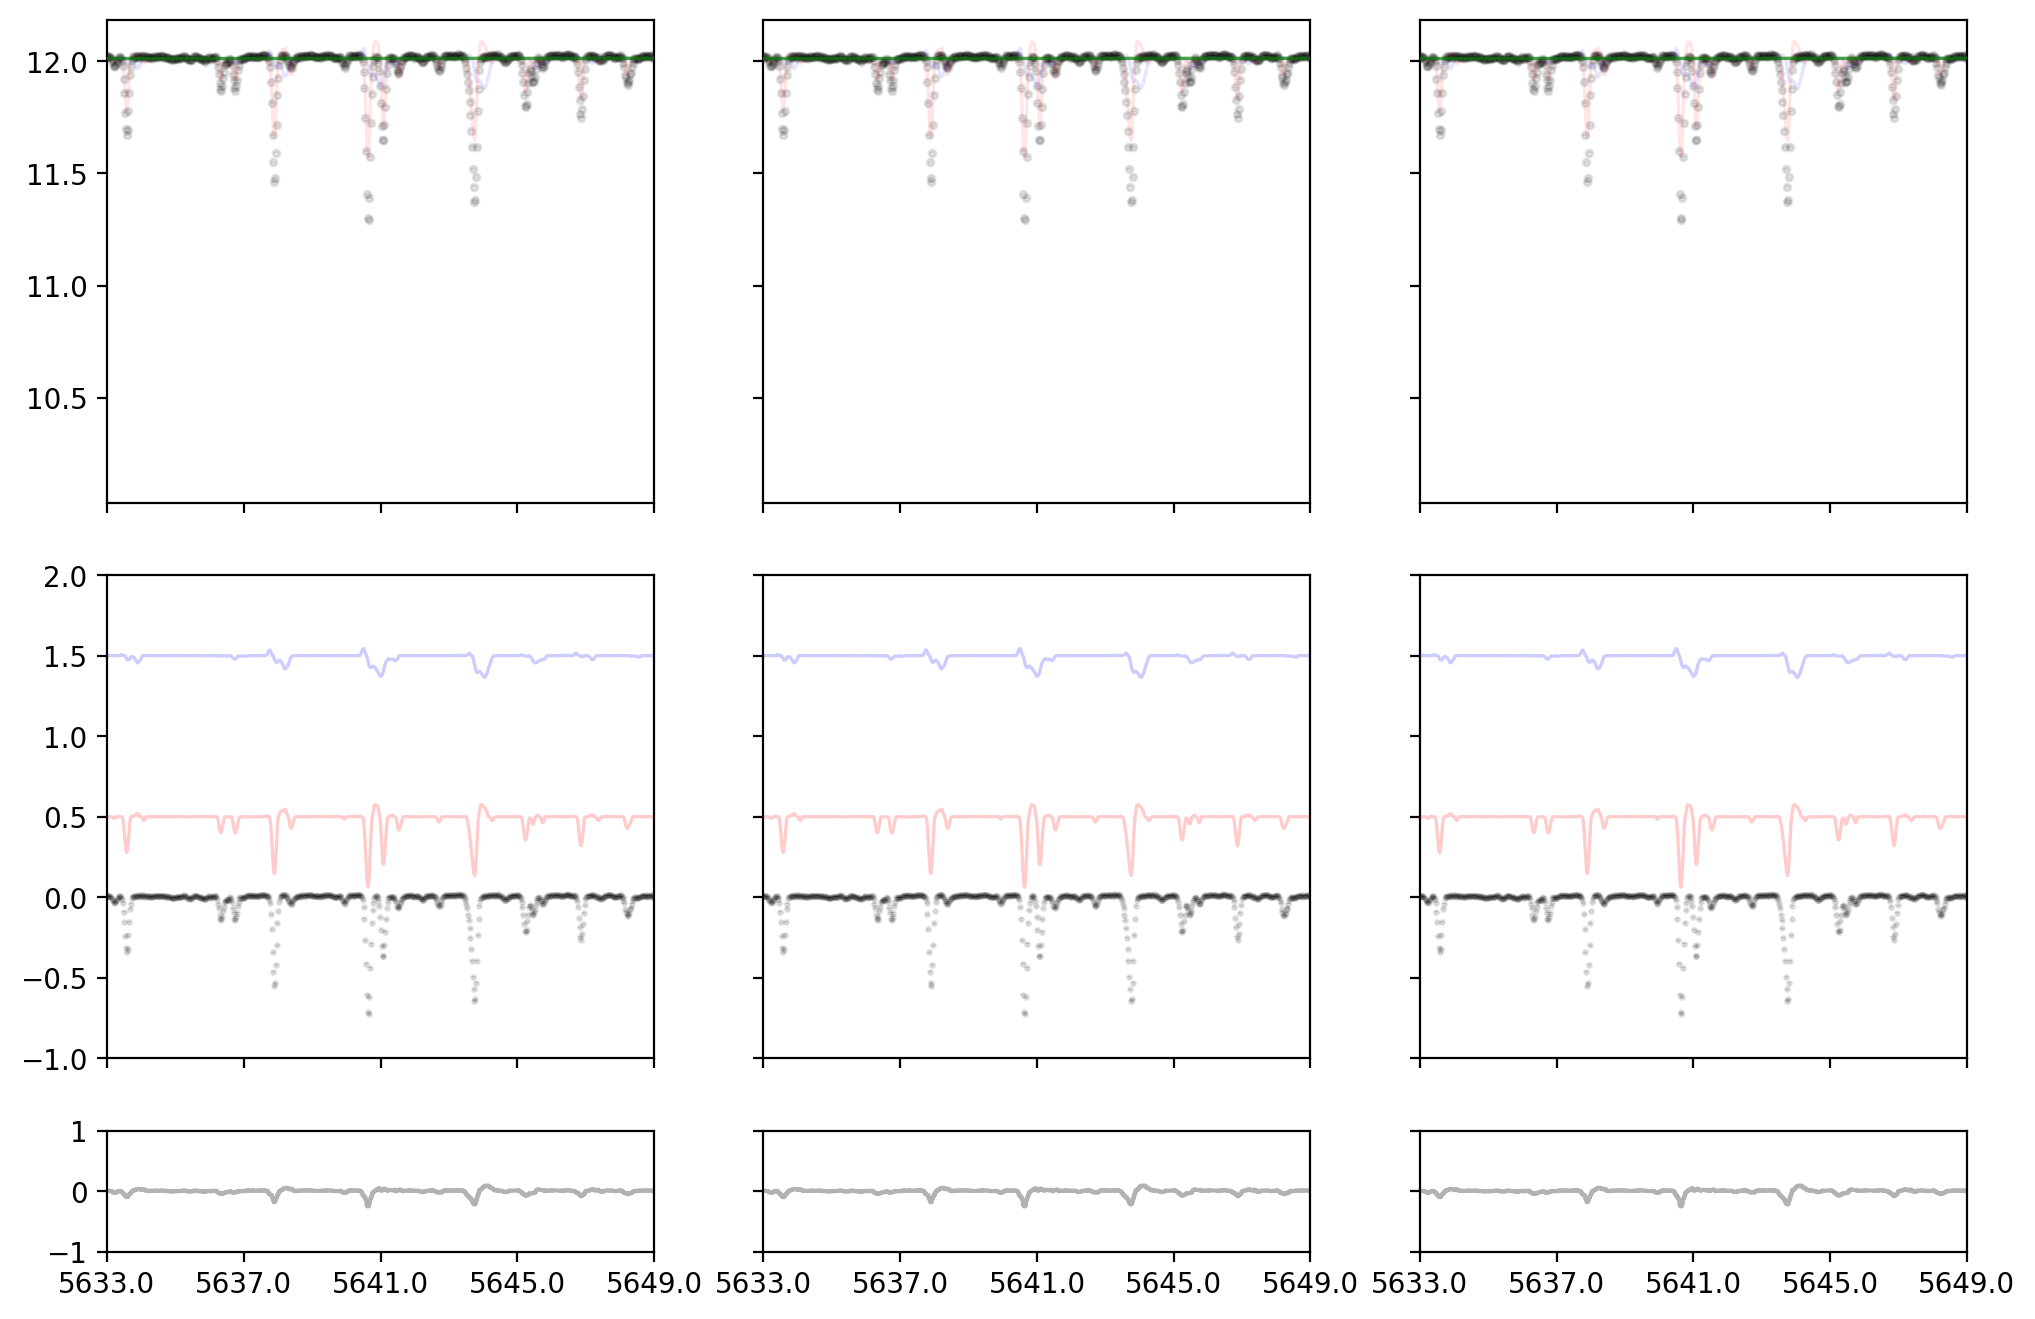

In [26]:
# for model,dataset in zip(all_models,all_data):
this_fucking_plot(dataset,model)

58905.0367628588


TypeError: cannot unpack non-iterable DataBlock object

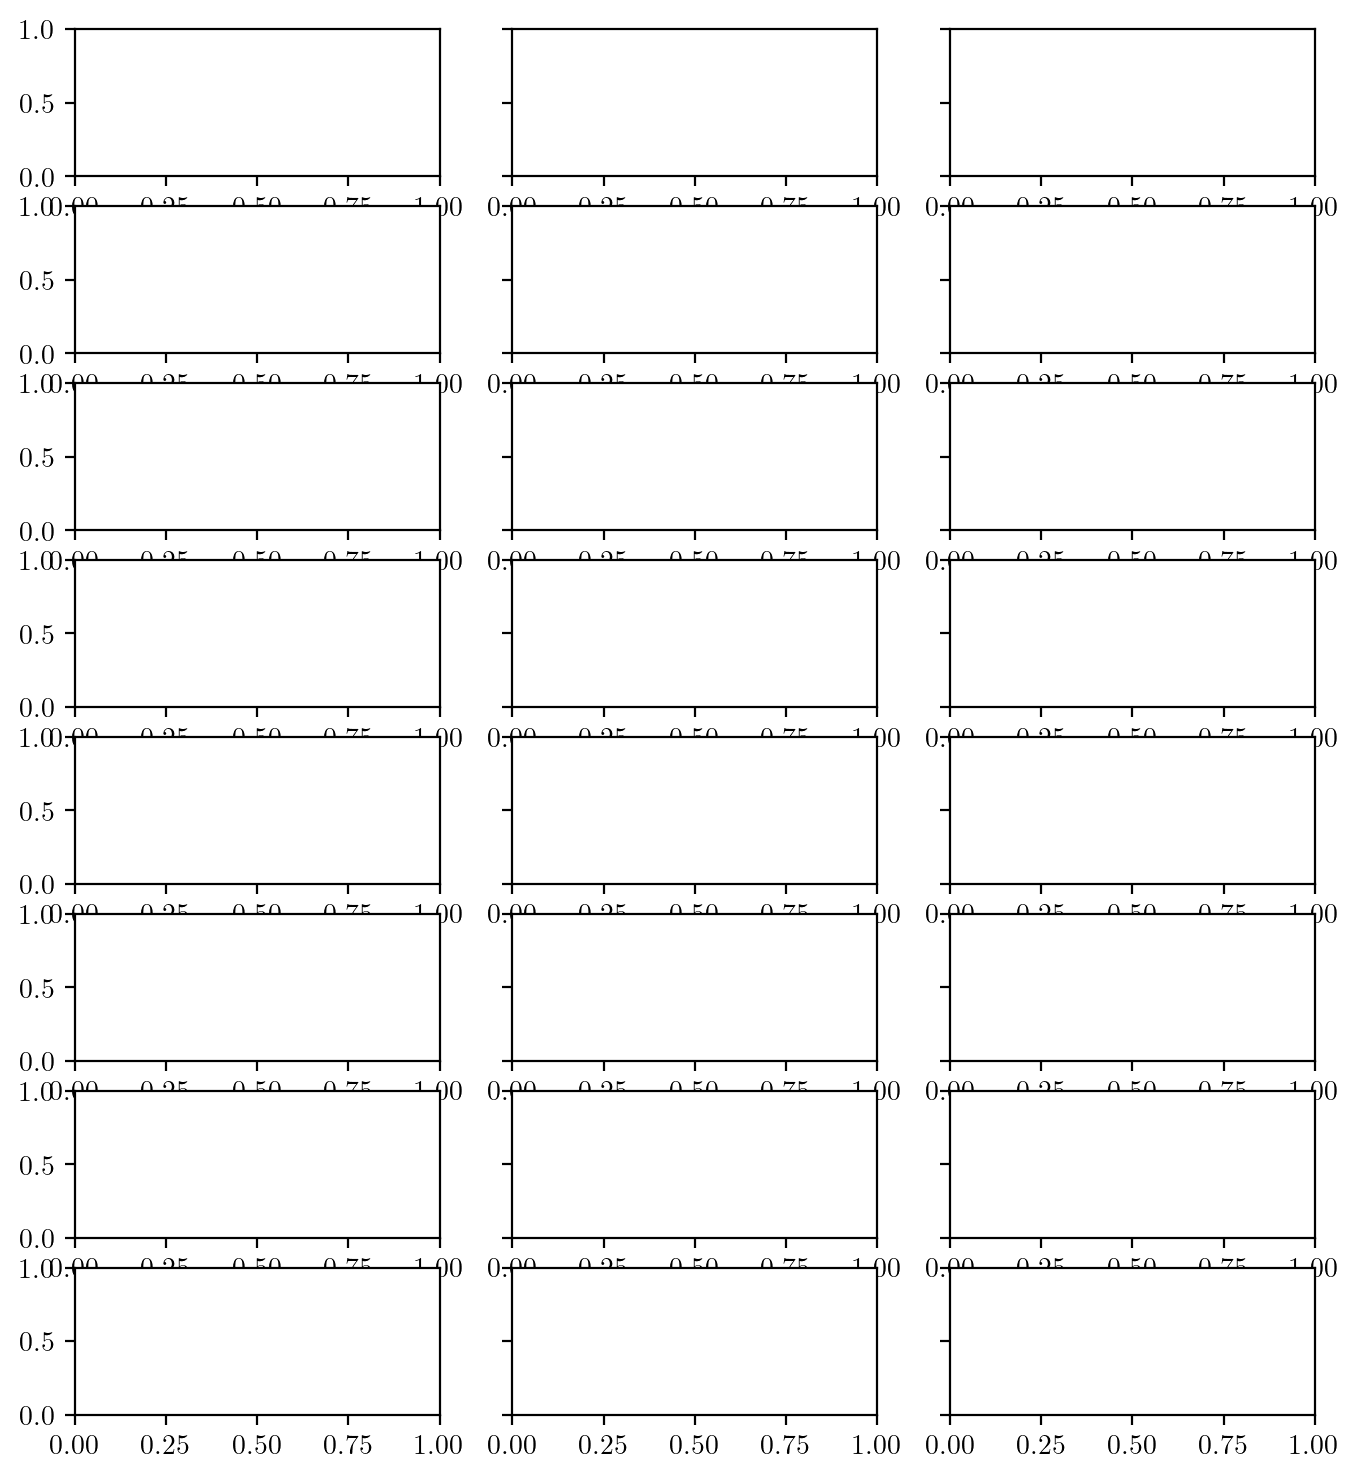

In [27]:
import matplotlib 
matplotlib.rcParams['text.usetex'] = True
def make_grid_plots(datasets,models,size_n,size_m,plt_epochs,device,line_list=None,l_width=np.arange(-4,4,2)):
    # l_width = 
    
    fig, axes = plt.subplots(2*size_n,size_m,figsize=(3*size_m,2*size_n),sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1]*size_n,dpi=200)
    # plt.tight_layout()

    for ii, nn in enumerate(range(size_n)):
        for jj, mm in enumerate(range(size_m)):
            this_index = size_m*ii+jj
            
            lrange = np.floor(np.exp(datasets[this_index].xs[plt_epochs[this_index]]).mean()) + l_width
            # print(lrange)
            axes[2*ii:((2*ii)+2),jj] = make_subplot(axes[2*ii:((2*ii)+2),jj],models[this_index],datasets[this_index],plt_epochs[this_index],device,lrange)
            if "orders" in models[this_index].metadata:
        
                text = axes[2*ii,jj].text(np.log(lrange.min()+0.1),-2.4,\
                                          "Order: ${}$".format(models[this_index].metadata["orders"][plt_epochs[this_index]]))
                # text.fontsize = 16
    
            if line_list is not None:
                plot_line_list(axes[2*ii:((2*ii)+2),jj],line_list,lrange)
    plt.subplots_adjust(top=1.3)

    return fig, axes

# for model in all_models:
#     print(model.results)
lmin = [np.exp(np.min(model[0][1].xs)) for model in all_models]
lmax = [np.exp(np.max(model[0][1].xs)) for model in all_models]

plt_lambdas = np.linspace(4000,7000,12)

model_inds = [np.array(np.where((plt_lambda > lmin) * (plt_lambda < lmax))).squeeze() for plt_lambda in plt_lambdas]
l_means = np.concatenate([[plt_lambdas[ii]]*xx.shape[0] if len(xx.shape) != 0 else [plt_lambdas[ii]] for ii,xx in enumerate(model_inds)])
# print(model_inds)
model_inds = np.concatenate([np.array([xx]) if len(xx.shape) == 0 else xx for xx in model_inds])
# print(len(model_inds))
size_n = 3
size_m = 4
model_inds= model_inds[:size_n*size_m]
fig, axes = plt.subplots(2*size_m,size_n,figsize=(2*size_m,3*size_n),sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,4] * size_m,dpi=200)


plt_width = np.linspace(-24,24,2)
lrange = l_means.astype(int)[None,:] + plt_width[:,None]
plt_time = all_data[0].metadata['times'][0]
print(plt_time)

plt_name = "{}_spectra_norm_{}.png".format(star_name,plt_time)

# print(axes.shape,size_m,size_n)

for ii, (dataset, model) in enumerate(zip([all_data[jj] for jj in model_inds ],[all_models[jj]for jj in model_inds ])): 
    jj = ii//size_n
    kk = ii % size_n
    
    data, meta = dataset.blockify(cpus[0])
    epoches_check, = np.where(dataset.metadata['times'] == plt_time)
    plt_epoch = epoches_check[0]
    
    for epoch in epoches_check:
        # print(lrange[:,ii].mean(), np.exp(dataset.xs[epoch]).min(),np.exp(dataset.xs[epoch]).max())
        # print((lrange[:ii].mean() > np.exp(dataset.xs[epoch]).min()),(lrange[:ii].mean() < np.exp(dataset.xs[epoch]).max()))
        if lrange[:,ii].mean() > np.exp(dataset.xs[epoch]).min() and np.exp(dataset.xs[epoch]).max() > lrange[:,ii].mean():
            plt_epoch = epoch
            # print(epoch)
    axes[2*jj,kk] = make_subplot_norm(axes[2*jj,kk],model,dataset,dataset,plt_epoch,cpus[0],lrange[:,ii])

    dum_fig,dum_axes = plt.subplots(1)
    # dummy_axe = plt.Axes(dumm_fig)
    axes[(2*jj+1),kk] = make_subplot(np.array((axes[(2*jj+1),kk],dum_axes)),model,dataset,plt_epoch,cpus[0],lrange[:,ii])[0]
    axes[(2*jj+1),kk].set_xticklabels(dum_axes.get_xticklabels())
    # axes[2*jj,kk].set_ylim(0,100)
    # axes[(2*jj+1),kk].set_ylim(0,100)
    plt.close(dum_fig)
fig.text(0.5, 0.07, 'Wavelength [$\\AA$]', ha='center')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig(os.path.join(out_dir,plt_name))
plt.show()

In [ ]:
def plt_rv_comparison(times, rv_e, err_e, times_comb, rv_comb, err_comb, targ_time, targ_vel, \
                      targ_err, bervs, star_name, out_dir):
    epoches_span = np.arange(0, len(times_comb), dtype=int)

    # RV Comparison

    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))


    bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    norm_vel   = bervs_temp

    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))

    bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    norm_vel   = bervs_temp #(targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean())
    # print(np.sum(times_comb == targ_time[targ_ind][comb_indi]))

    targ_norm = (targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean()) - norm_vel
    targ_line = ax.errorbar(epoches_span,targ_norm,targ_err[targ_ind][comb_indi],fmt='.g',zorder=3,alpha=0.5,ms=2,label='CCF RV')

    
    comb_norm = (rv_comb - rv_comb.mean()) + norm_vel
    comb_line = ax.errorbar(epoches_span,comb_norm,err_comb,fmt='.r',zorder=2,alpha=0.3,ms=2,label='Order Jabble Combined RV')

    temp_vel = (rv_e.mean(axis=0) - rv_e.mean()) #+ bervs_temp[targ_ind][comb_indi]
    avg_line = ax.errorbar(epoches_span,temp_vel,0.0,fmt='.b',zorder=2,alpha=0.0,ms=2,label='Avg RV')

    for i in range(rv_e.shape[0]):
        e_ind = np.argsort(times[i,:])
        indiv_norm = (rv_e[i,:][e_ind][comb_indi] - rv_e[i,:].mean()) + norm_vel
        # times[i,:][e_ind][comb_indi]
        err_line = ax.errorbar(epoches_span,indiv_norm,yerr=err_e[i,:][e_ind][comb_indi],fmt='.k',zorder=1,alpha=0.03,ms=2,label='Order Jabble RV')

    # ax.set_ylim(-100, 100)
    ax.legend(handles=[targ_line,comb_line,err_line],loc="lower right")

    # ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "Epochs")
    # ax.set_xlim(2.456e6 + 451,2.456e6+452)
    ax.set_ylim(-10_000,10_000)
    plt.savefig(os.path.join(out_dir, "{}_rvs_epoch.png".format(star_name)),bbox_inches='tight')
    plt.show()

def plt_rv_comparison_time(times, rv_e, err_e, times_comb, rv_comb, err_comb, targ_time, targ_vel, \
                      targ_err, bervs, star_name, out_dir, period):
    epoches_span = np.arange(0, len(times_comb), dtype=int)

    # RV Comparison

    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))


    bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    norm_vel   = bervs_temp

    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))

    bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    norm_vel   = bervs_temp #(targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean())
    # print(np.sum(times_comb == targ_time[targ_ind][comb_indi]))

    targ_norm = (targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean()) - norm_vel
    targ_line = ax.errorbar(targ_time[targ_ind][comb_indi] % period,targ_norm,targ_err[targ_ind][comb_indi],\
                            fmt='.g',zorder=3,alpha=0.5,ms=2,label='CCF RV')

    
    comb_norm = (rv_comb - rv_comb.mean()) + norm_vel
    comb_line = ax.errorbar(times_comb % period,comb_norm,err_comb,fmt='.r',zorder=2,alpha=0.3,ms=2,\
                            label='Order Jabble Combined RV')

    temp_vel = (rv_e.mean(axis=0) - rv_e.mean()) #+ bervs_temp[targ_ind][comb_indi]
    avg_line = ax.errorbar(times_comb % period,temp_vel,0.0,fmt='.b',zorder=2,alpha=0.0,ms=2,label='Avg RV')

    for i in range(rv_e.shape[0]):
        e_ind = np.argsort(times[i,:])
        indiv_norm = (rv_e[i,:][e_ind][comb_indi] - rv_e[i,:].mean()) + norm_vel
        # times[i,:][e_ind][comb_indi]
        err_line = ax.errorbar(times[i,:] % period,indiv_norm,yerr=err_e[i,:][e_ind][comb_indi],fmt='.k',\
                               zorder=1,alpha=0.03,ms=2,label='Order Jabble RV')

    # ax.set_ylim(-100, 100)
    ax.legend(handles=[targ_line,comb_line,err_line],loc="lower right")

    # ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "Days")
    # ax.set_xlim(2.456e6 + 451,2.456e6+452)
    ax.set_ylim(-10_000,10_000)
    plt.savefig(os.path.join(out_dir, "{}_rvs_epoch.png".format(star_name)),bbox_inches='tight')
    plt.show()

plt_rv_comparison_time(all_rv_array['Time_all'], all_rv_array['RV_all'], all_rv_array['RV_err_all'],\
                  rv_array['Time_comb'], rv_array['RV_comb'], rv_array['RV_err_comb'],\
                  obs_times.mjd, rv.to(u.m/u.s).value, \
                  np.ones(rv.shape)*0.01, -bc.to(u.m/u.s).value, star_name, out_dir,period.to(u.day).value)


<h2>fit with only stellar model!</h2>

In [ ]:
def plot_rv_error(times,err_e,times_comb,err_comb,targ_time,\
                  targ_err,star_name,\
                  out_dir):
    
    epoches_span = np.arange(0,len(times_comb),dtype=int)

    # RV Err Comparison
    
    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))

    # bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    # norm_vel   = bervs_temp #(targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean())
    # print(np.sum(times_comb == targ_time[targ_ind][comb_indi]))

    # targ_norm  = (targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean()) - norm_vel
    targ_line = ax.plot(epoches_span,targ_err[targ_ind][comb_indi],'.g',zorder=3,alpha=0.5,ms=2,label='HARPS RV')

    
    # comb_norm = (rv_comb - rv_comb.mean()) - norm_vel
    comb_line = ax.step(epoches_span,err_comb,'r',where='mid',zorder=1,alpha=0.3,ms=2,label='Order Jabble Combined RV')

    # ax.set_title('Barnard\'s Star Relative Radial Velocity Error')
    ax.set_ylabel("RV Error [$m/s$]")
    ax.set_xlabel( "Epochs")
    # ax.set_xlim(2.4564e6,2.45644e6)
    ax.set_ylim(-1e1,1e3)
    # plt.savefig(os.path.join(out_dir, "{}_rvs_err_epoch.png".format(star_name)),bbox_inches='tight')
    plt.show()
    


In [ ]:
# , all_rv_array['RV_all'], ],\
#                   , rv_array['RV_comb'], ,\
#                   , ccf_arr_obj['ccf_rvs']/1000 -  ccf_arr_obj['bervs'], \
#                   , ccf_arr_obj['bervs'], star_name, out_dir
plot_rv_error(all_rv_array['Time_all'],all_rv_array['RV_err_all'],rv_array['Time_comb'],\
              rv_array['RV_err_comb'],obs_times.mjd,\
              rv,star_name,out_dir)

In [ ]:
ccf_arr_obj['ccf_rvs'] - ccf_arr_obj['ccf_rvs'].mean()

In [ ]:
temp = rv_array['RV_comb'] + ccf_arr_obj['bervs']
print(temp - temp.mean())